In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch.nn as nn
import torch
import math

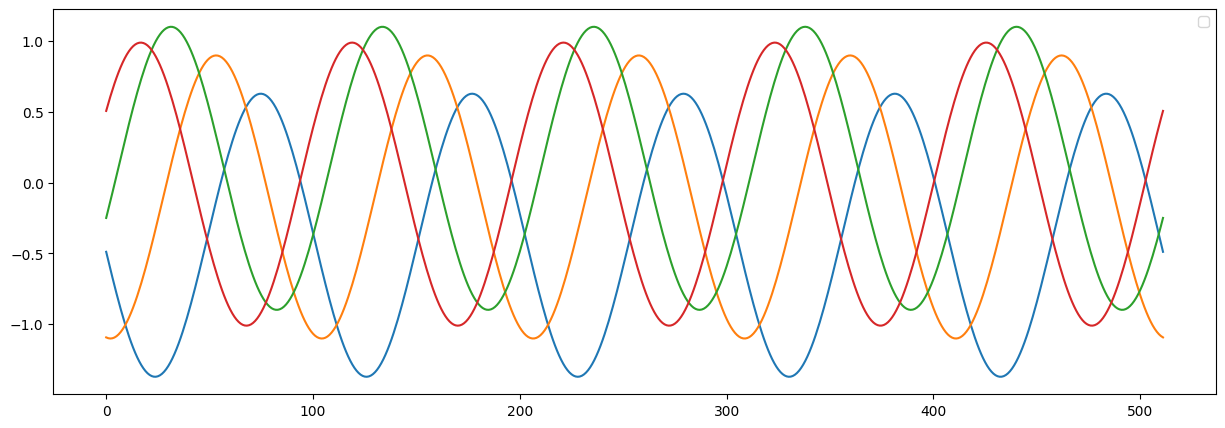

In [6]:
n = 5
r = 1024
x = torch.linspace(0, n*2*np.pi, 256*2)
x2 = x.unsqueeze(1).repeat_interleave(r, dim=1)
y = torch.sin(x2 + torch.normal(0., np.pi, size=(1,x2.shape[1])))
y += torch.normal(0., 0.2, size=(r,))

plt.figure(figsize=(15,5))
sns.lineplot(data=y[:,[1,2,3,4]].numpy(), dashes=False)
plt.legend([], [])
plt.show()

y_grad = torch.tensor(np.gradient(y, axis=0)).transpose(0, 1)

In [13]:
def variance_schedule(t_max=4000, s=0.008, max_beta=0.999):
    # https://github.com/ageron/handson-ml3/blob/main/17_autoencoders_gans_and_diffusion_models.ipynb
    t_tensor = torch.arange(t_max)
    f = torch.cos((t_tensor / t_max + s) / (1 + s) * np.pi / 2) ** 2
    alpha = torch.clamp(f[1:] / f[:-1], 1 - max_beta, 1)
    alpha = torch.cat([torch.tensor(1).unsqueeze(dim=0), alpha]).float()
    beta = 1 - alpha
    alpha_cumprod = torch.cumprod(alpha, 0)
    return alpha, alpha_cumprod, beta  # αₜ , α̅ₜ , βₜ for t = 0 to T

alpha, alpha_cumprod, beta = variance_schedule()

torch.Size([3999])

In [4]:
def conv_out_size(conv_in, kernel_size, stride=1):
    # assumes no padding
    return math.floor((conv_in - (kernel_size - 1) - 1) / stride + 1)

def single_conv(in_channels, out_channels, kernel_size=3, pad=True):
    layer = nn.Sequential(
        nn.Conv1d(
            in_channels, 
            out_channels, 
            kernel_size, 
            padding=0 if not pad else math.floor(kernel_size / 2),
        ),
        nn.BatchNorm1d(out_channels),
        nn.ReLU(inplace=True),
    )
    return layer

def double_conv(in_channels, out_channels, **conv_kwargs):
    layer = nn.Sequential(
        single_conv(in_channels, out_channels, **conv_kwargs),
        single_conv(out_channels, out_channels, **conv_kwargs),
    )
    return layer

def triple_conv(in_channels, mid_channels, out_channels, **conv_kwargs):
    layer = nn.Sequential(
        single_conv(in_channels, mid_channels, **conv_kwargs),
        single_conv(mid_channels, mid_channels, **conv_kwargs),
        single_conv(mid_channels, out_channels, **conv_kwargs),
    )
    return layer

class Unet1d(nn.Module):
    def __init__(
        self, 
        init_upscale=8,
        n_blocks=3,
        depth_factor=3,
        kernel_size=3,
        stride=2,
        in_channels=1,
    ):
        super(Unet1d, self).__init__()
        self.conv_down_blocks = list()
        self.pool_down_layers = list()
        self.conv_up_blocks = list()
        self.tran_up_layers = list()
        assert kernel_size % 2

        self.input = single_conv(in_channels, init_upscale)
        channels = init_upscale
        for i in range(n_blocks):
            self.conv_down_blocks.append(
                double_conv(
                    channels, 
                    channels * depth_factor,
                )
            )
            channels *= depth_factor
            self.pool_down_layers.append(
                nn.MaxPool1d(stride)
            )
            
        self.mid_layer = triple_conv(channels, channels * depth_factor, channels)
        for i in range(n_blocks):
            self.tran_up_layers.append(
                nn.ConvTranspose1d(
                    channels, 
                    channels, 
                    kernel_size, 
                    stride,
                    padding=math.floor(kernel_size / 2),
                    output_padding=1,
                )
            )
            self.conv_up_blocks.append(
                triple_conv(
                    channels, # * 2
                    channels, 
                    channels // depth_factor,
                )
            )
            channels //= depth_factor
            
        self.output = single_conv(channels, 1)
        return
           
    def forward(self, x):
        original_shape = x.shape
        residuals = list()
        x = self.input(x)
        for conv_down_block, pool_down_layer in zip(self.conv_down_blocks, self.pool_down_layers):
            x = conv_down_block(x)
            residuals.append(x)
            x = pool_down_layer(x)
            
        x = self.mid_layer(x)
        for conv_up_block, residual, tran_up_layer in zip(self.conv_up_blocks, reversed(residuals), self.tran_up_layers):
            x = tran_up_layer(x)
            x = torch.add(x, residual)
            x = conv_up_block(x)

        x = self.output(x)
        assert x.shape == original_shape, f'{x.shape} != {original_shape}'
        x = torch.sigmoid(x)
        return x

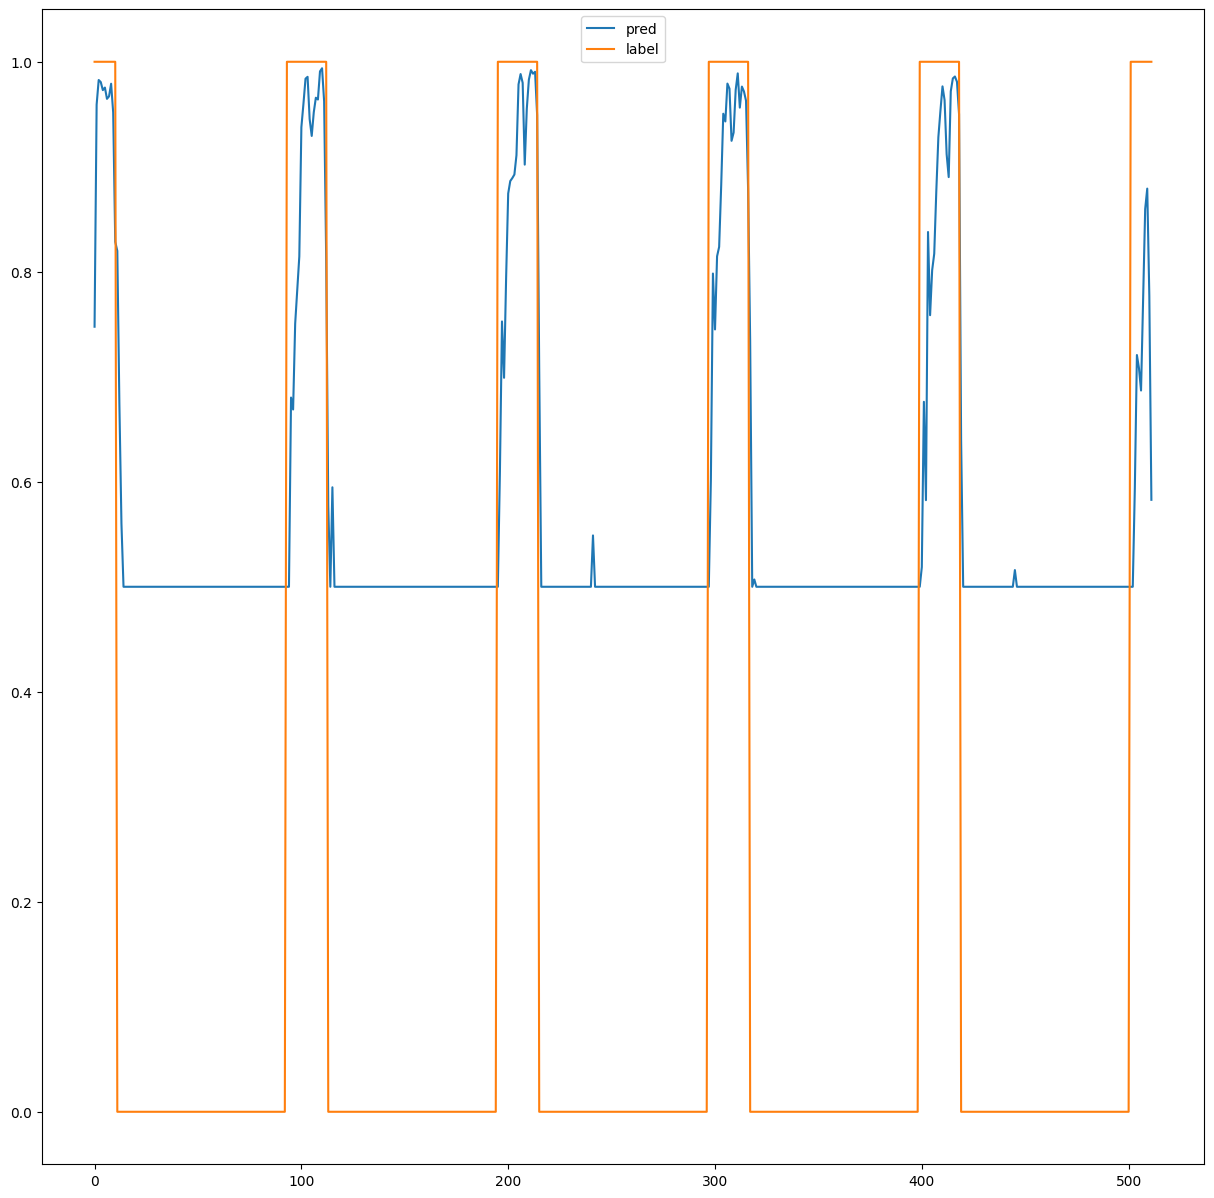

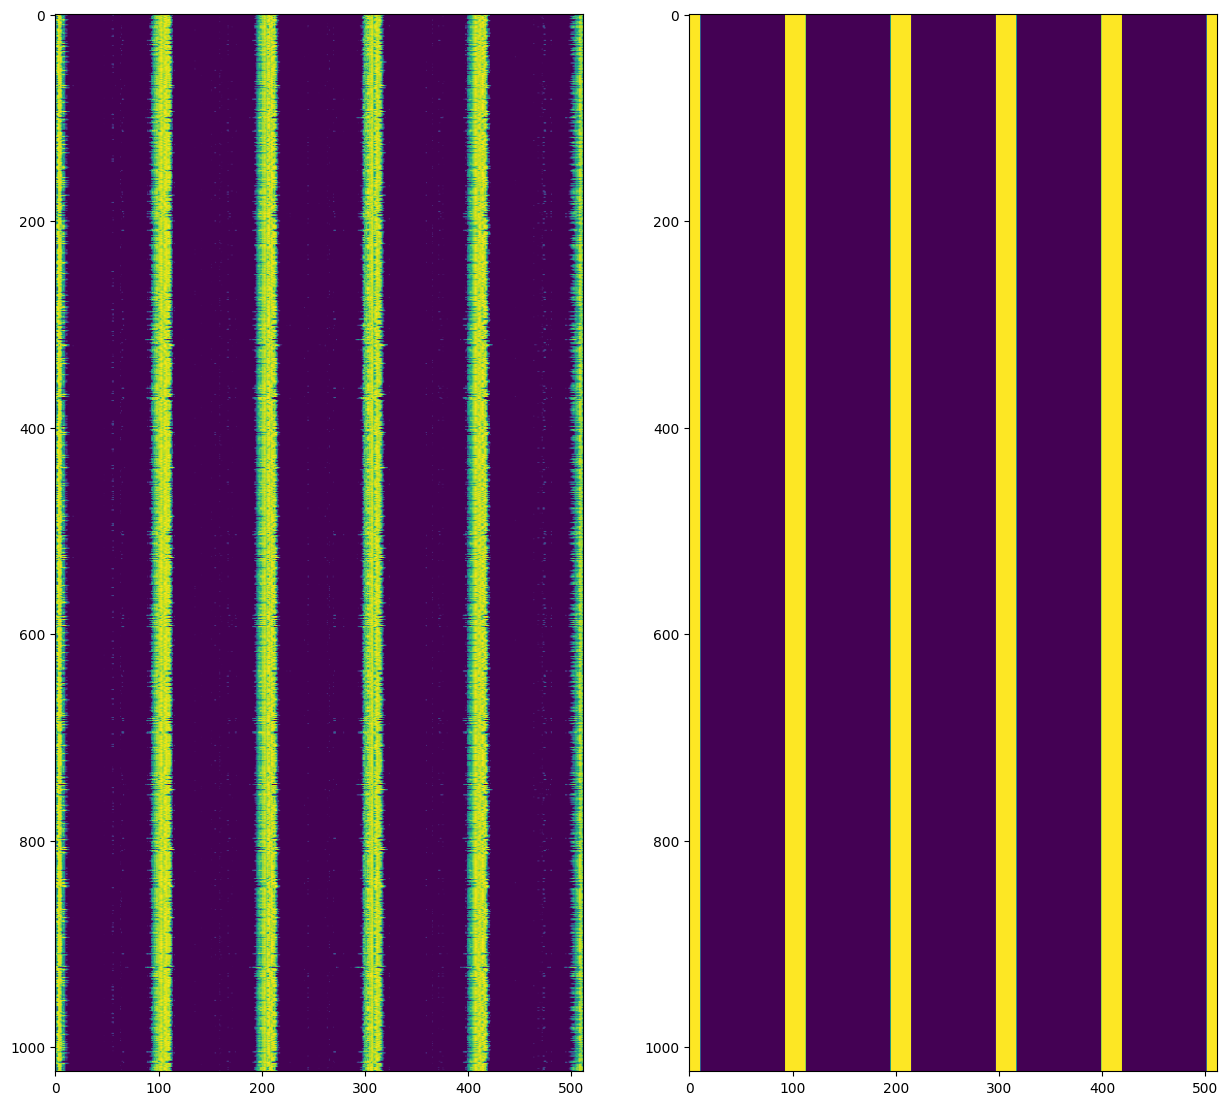

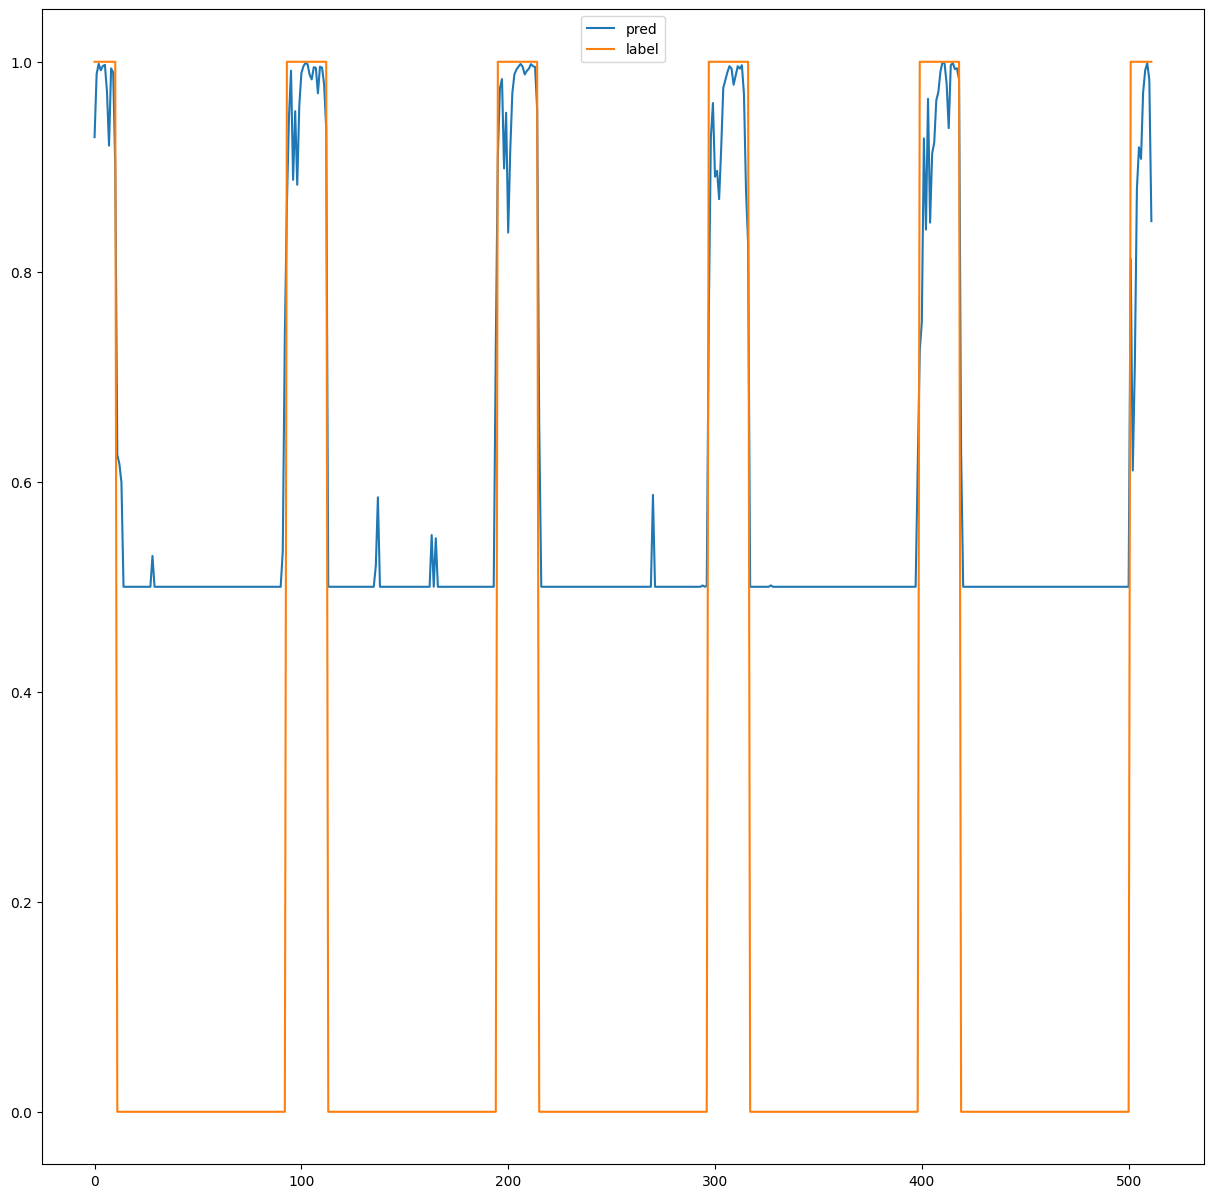

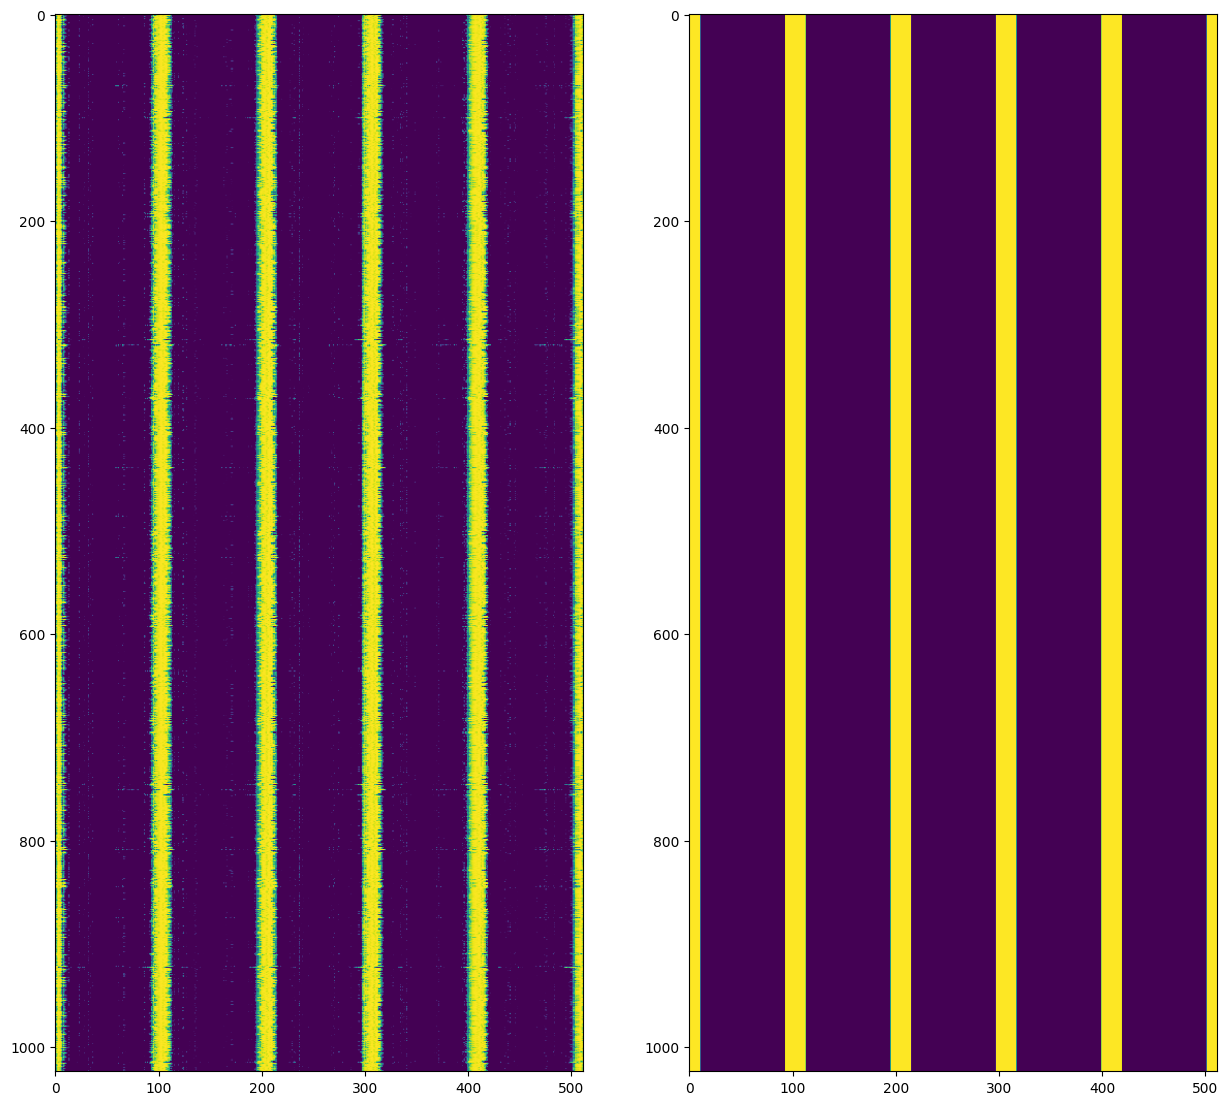

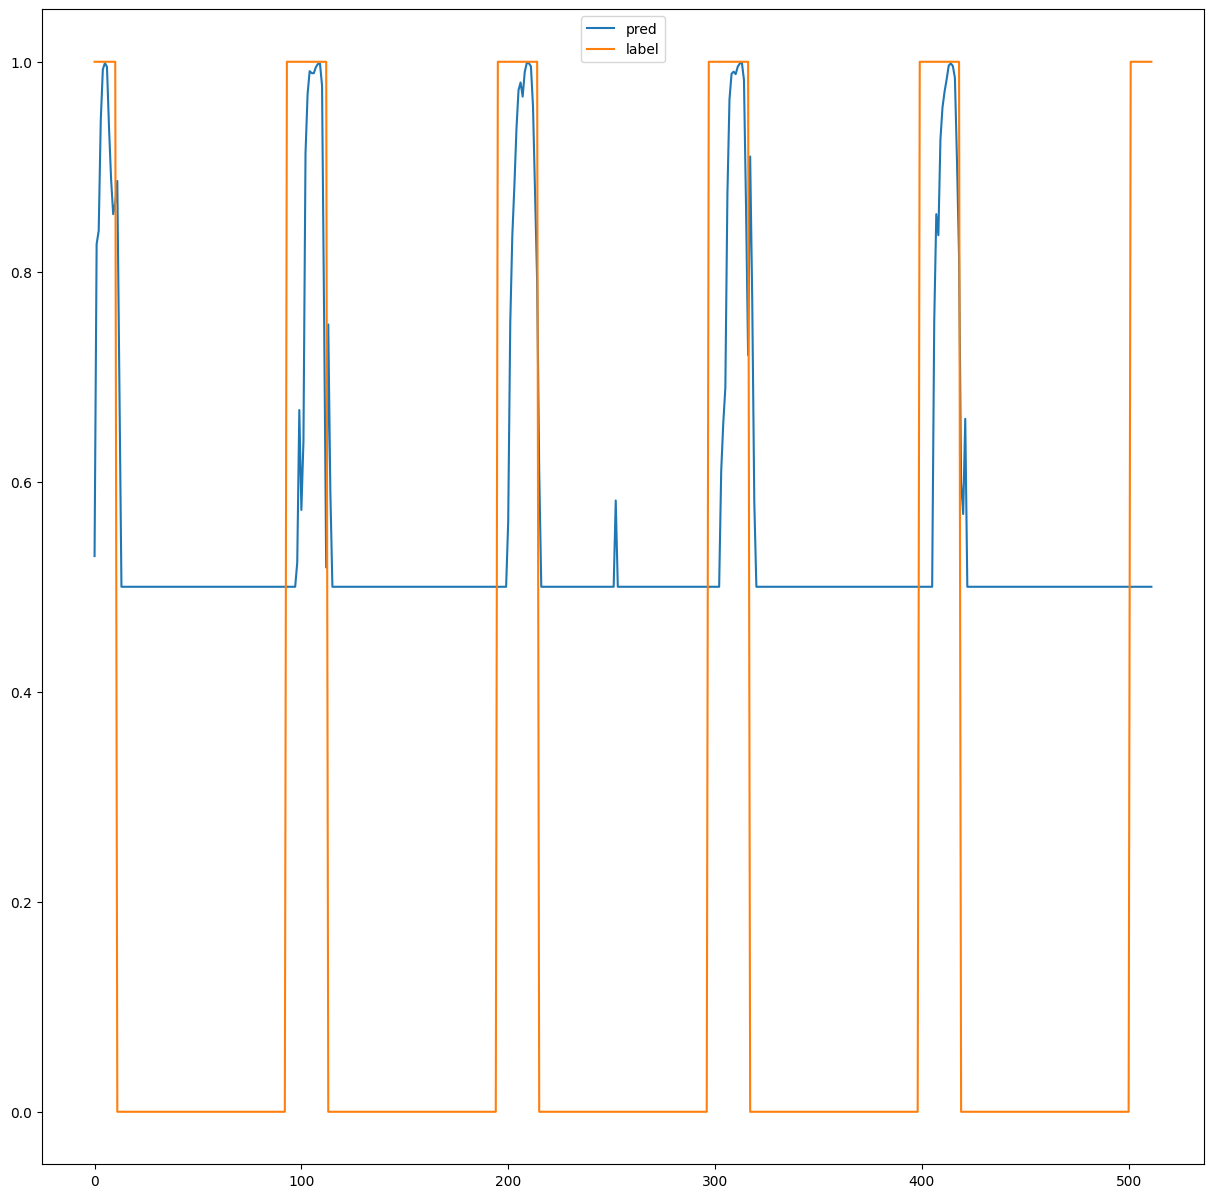

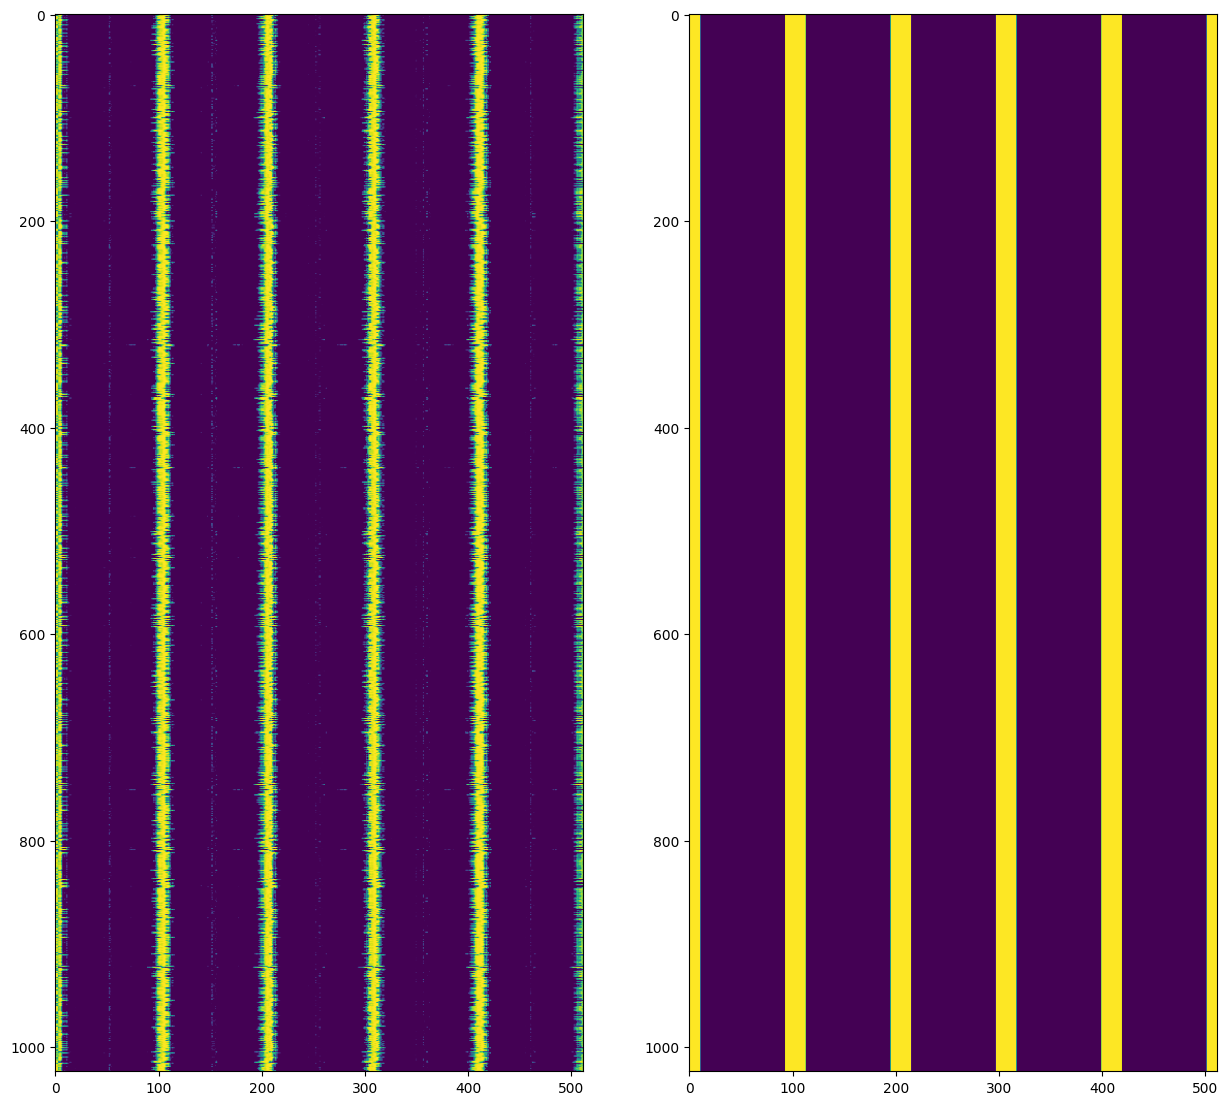

KeyboardInterrupt: 

In [6]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

n_epochs = 380

model = Unet1d(n_blocks=5, kernel_size=17)

optimizer = optim.NAdam(model.parameters(), lr=.1)
# annealer = lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min=1e-5)
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.SmoothL1Loss()

norm_data = (data - data.mean()) / data.std()
model_loss = list()
for epoch in range(n_epochs):
    if not epoch % 10:
        print(epoch, end='\r')
    optimizer.zero_grad()
    preds = model(norm_data)
        
    loss = criterion(preds, noise)
    loss.backward()
    
    model_loss.append(loss.item())
    optimizer.step()
#     annealer.step()